In [1]:
import numpy as np
import pandas as pd
import os

datadir = os.path.join('..', 'WISDM_at_v2.0')
raw_headers = ['user','activity','time','x','y','z']
act_headers = ['user','X0','X1','X2','X3','X4','X5','X6','X7','X8','X9','Y0','Y1','Y2','Y3','Y4','Y5','Y6','Y7','Y8','Y9','Z0','Z1','Z2','Z3','Z4','Z5','Z6','Z7','Z8','Z9','XAVG','YAVG','ZAVG','XPEAK','YPEAK','ZPEAK','XABSOLDEV', 'YABSOLDEV','ZABSOLDEV','XSTANDDEV','YSTANDDEV','ZSTANDDEV','Resultant','Activity']


In [5]:
labelled_act = os.path.join(datadir,'WISDM_at_v2.0_transformed.csv')
labelled_raw = os.path.join(datadir, 'WISDM_at_v2.0_raw.txt')
unlabelled_act = os.path.join(datadir,'WISDM_at_v2.0_unlabeled_transformed.csv')
unlabelled_raw = os.path.join(datadir, 'WISDM_at_v2.0_unlabeled_raw.txt')
raw_data = pd.read_csv(unlabelled_raw, header=None, names = raw_headers, parse_dates=True)
act_data = pd.read_csv(unlabelled_act, header=None, names = act_headers) 
lab_raw = pd.read_csv(labelled_raw, header=None, names = raw_headers, parse_dates=True)
lab_act = pd.read_csv(labelled_act, header=None, names = act_headers)
demo_headers = ['user','height','gender','age','weight','leg_injury']
demo = unlabelled_raw = os.path.join(datadir, 'WISDM_at_v2.0_demographics.txt')
demographics = pd.read_csv(demo, header=None, names = demo_headers)

In [5]:
print "concat raw"
#raw_data = pd.concat([unlabelled_raw_data, raw_data])
#raw_data = unlabelled_raw_data
#act_data = unlabelled_act_data
#del unlabelled_raw_data
print "concat act"
#act_data = pd.concat([unlabelled_act_data, act_data])
#del unlabelled_act_data
print "concat over"

lab_raw = lab_raw.loc[lab_raw['time']>0]
lab_raw['time'] = pd.to_datetime(lab_raw['time'], unit = 'ms', errors='coerce')
raw_data = raw_data.loc[raw_data['time']>0]
raw_data['time'] = pd.to_datetime(raw_data['time'], unit = 'ms', errors='coerce')

concat raw
concat act
concat over


In [6]:
#users in unlabelled set
users = list(set(raw_data.user.unique()).intersection(set(act_data.user.unique())))
print len(users)
time_user_raw = raw_data[['user','time']]
user_duration = time_user_raw.groupby('user').agg({'time':[min,max]})
user_duration.columns = ["_".join(x) for x in user_duration.columns.ravel()]
user_duration['duration'] = user_duration['time_max'] - user_duration['time_min']
#print user_duration.sort_values(by='duration').loc[act_data.user.unique()]['duration']
user_duration = user_duration.loc[users]
user_duration = user_duration[(user_duration['duration'].dt.total_seconds()) > 10800]
#users in labelled set
lab_users = list(set(lab_raw.user.unique()).intersection(set(lab_act.user.unique())))
#common users
comm_users = list(set(lab_users).intersection(set(users)))

time_user_raw_l = lab_raw[['user','time']]
time_user_raw_l = time_user_raw_l.loc[time_user_raw_l['user'].isin(comm_users)]
user_duration_l = time_user_raw_l.groupby('user').agg({'time':[min,max]})
user_duration_l.columns = ["_".join(x) for x in user_duration_l.columns.ravel()]
user_duration_l['duration'] = user_duration_l['time_max'] - user_duration_l['time_min']
user_duration_l = user_duration_l[(user_duration_l['duration'].dt.total_seconds()) > 10800]

#remove common users with overlapping durations
overlapped = []
for usr in comm_users:
    lstime = user_duration_l.loc[user_duration_l.index==usr]['time_min'].values
    letime = user_duration_l.loc[user_duration_l.index==usr]['time_max'].values
    stime = user_duration.loc[user_duration.index==usr]['time_min'].values
    etime = user_duration.loc[user_duration.index==usr]['time_max'].values
    #print lstime,letime, stime, etime
    if (lstime>stime and lstime<etime) or (letime>stime and letime<etime) or (lstime<stime and letime>etime):
        overlapped.append(usr)

all_users = users
users = [usr for usr in all_users if (usr not in overlapped) and ((usr in user_duration.index) or (usr in user_duration_l.index))]

#filter all suitable users from labelled and unlabelled set and concat
unlabelled_raw_data = raw_data.loc[raw_data['user'].isin(users)]
unlabelled_act_data = act_data.loc[act_data['user'].isin(users)]
labelled_raw_data = lab_raw.loc[lab_raw['user'].isin(users)]
labelled_act_data = lab_act.loc[lab_act['user'].isin(users)]

raw_data = pd.concat([labelled_raw_data,unlabelled_raw_data])
del labelled_raw_data
del unlabelled_raw_data
act_data = pd.concat([labelled_act_data, unlabelled_act_data])
del labelled_act_data
del unlabelled_act_data

#print user_duration.sort_values(by='duration')['duration']
#users = user_duration.index

143


C:\ProgramData\Anaconda2\lib\site-packages\ipykernel_launcher.py:31: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.


In [5]:
print users
activity_duration = {'Walking': 0, 'Jogging': 1, 'Standing': 2, 'Sitting': 3, 'Stairs': 4, 'LyingDown': 5}
user_feats = []
act_feats = []
#users = []
nan_users = {}
user_no = 0
seq = []
for userid in users:
    user_act_data = act_data.loc[act_data['user']==userid]['Activity']
    prev = user_act_data.iloc[0]
    #feat = [walk_dur, jog_dur, stand_dur, sit_dur, stair_dur, ly_dur, no_tx, walk_jog, walk_sit, sit_walk]
    feat = [0.0]*7
    txfeat = [0.0]*36
    tot_dur = 0
    act_seq = []
    for i,activity in user_act_data.iteritems():
        if tot_dur<259200:
            if activity_duration.get(activity, -1)==-1:
                nan_users[userid] = i        
                print userid, activity
            feat_index = activity_duration.get(activity, -1)
            seq.append((user_no,tot_dur,feat_index))
            if feat_index != -1:
                act_seq.append(feat_index)
                feat[feat_index] = feat[feat_index] + 1
                if activity!= prev:
                    feat[6] = feat[6] + 1
                    pfeat_index = activity_duration.get(activity)
                    index = (6*pfeat_index)+feat_index
                    txfeat[index] = txfeat[index]+1
                prev = activity
            #else:
                #print userid, activity
            tot_dur = tot_dur + 1
        else:
            break
    dfeat = [x/tot_dur for x in feat[:-1] ]
    if feat[6]!=0:
        txfeat = [x/feat[6] for x in txfeat ]
    ufeat = dfeat+txfeat
    act_feats.append(act_seq)
    user_feats.append(ufeat)
    #print act_seq
    #users.append(userid)
    user_no = user_no + 1
    
import pickle
pickle.dump(act_feats, open('activity_seq.dump','wb'))


[1550, 1556, 1058, 1064, 1577, 1804, 1104, 1634, 1647, 1140, 1664, 1685, 1696, 1702, 1191, 1193, 1736, 1726, 1233, 1748, 1239, 1753, 1758, 1769, 1791, 1793, 1801, 1802, 1294, 1314, 1763, 1775, 925, 1745, 1783, 1484, 1491, 1498, 1501, 1512, 1704, 1526]
[3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 

[2, 2, 2, 2, 3, 3, 2, 2, 5, 2, 2, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 5, 2, 3, 3, 3, 2, 3, 3, 5, 4, 3, 4, 4, 2, 4, 5, 5, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 3, 3, 5, 3, 3, 5, 5, 5, 3, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 

[3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 2, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 3, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 

[5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 3, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 3, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 3, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 

[4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4]
[2, 4, 5, 5, 5, 4, 4, 4, 4, 4, 2, 4, 2, 2, 2, 2, 2, 2, 4, 4, 2, 4, 2, 4, 2, 4, 2, 2, 4, 2, 2, 4, 4, 4, 4, 4, 4, 5, 5, 3, 3, 3, 5, 5, 5, 5, 5, 5, 5, 3, 5, 5, 5, 3, 3, 3, 3, 3, 5, 5, 3, 5, 5, 5, 5, 3, 3, 3, 5, 5, 5, 5, 5, 4, 4, 3, 3, 5, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 5, 5, 5, 5, 3, 3, 5, 5, 5, 5, 5, 5, 5, 3, 5, 5, 3, 5, 3, 5, 5, 5, 5, 5, 5, 5, 5, 5, 3, 5, 2, 2, 2, 5, 5, 5, 5, 2, 2, 3, 5, 5, 5, 5, 5, 5, 5, 5, 3, 5, 3, 5, 3, 5, 5, 5, 3, 3, 5, 3, 2, 3, 5, 3, 3, 5, 2, 2, 2, 5, 3, 5, 3, 5, 5, 3, 3, 5, 5, 2, 5, 5, 5, 3, 3, 5, 3, 5, 4, 4, 2, 2, 3, 5, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 4, 5, 5, 5, 5, 5, 5, 3, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 4, 4, 4, 4, 4, 2, 4, 2, 4, 4, 4, 4, 3, 3, 2, 4, 2, 4, 4, 4, 4, 4, 5, 5, 5, 5, 5, 5, 3, 5, 5, 3,

In [2]:
import pickle
act_feats = pickle.load( open( 'activity_seq.dump', "rb" ) )

user_id = 0
tx_seq = []
for act_seq in act_feats:
    for i, act in enumerate(act_seq):
        tx_seq.append((user_id,i,act))
    user_id = user_id + 1
print tx_seq

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [6]:
for userid in users:
    user_act_data = act_data.loc[act_data['user']==userid]['Activity']
    print user_act_data.head()

5033    Standing
5034    Standing
5035    Standing
5036    Standing
5037    Standing
Name: Activity, dtype: object
5139    Stairs
5140    Stairs
5141    Stairs
5142    Stairs
5143    Stairs
Name: Activity, dtype: object
5148    Sitting
5149    Sitting
5150    Sitting
5151    Sitting
5152    Sitting
Name: Activity, dtype: object
5332     Walking
5333    Standing
5334     Sitting
Name: Activity, dtype: object
3885    Standing
3886    Standing
3887    Standing
3888    Standing
3889    Standing
Name: Activity, dtype: object
3165    Walking
3166    Walking
3167    Walking
3168    Walking
3169    Walking
Name: Activity, dtype: object
3201    Walking
3202    Walking
3203    Walking
3204    Walking
3205    Walking
Name: Activity, dtype: object
3987    Sitting
3988    Sitting
3989    Sitting
3990    Sitting
3991    Sitting
Name: Activity, dtype: object
1979    Walking
1980    Walking
1981    Walking
1982    Walking
1983    Walking
Name: Activity, dtype: object
2550    Sitting
2551    Sitting
25

In [10]:
print users
print len(users)
print len(user_feats)
ufeats = np.array(user_feats)
print ufeats

[1550, 1556, 1058, 1064, 1577, 1104, 1634, 1140, 1664, 1685, 1696, 1702, 1191, 1193, 1736, 1726, 1233, 1748, 1239, 1753, 1758, 1769, 1791, 1793, 1801, 1802, 1294, 1314, 1763, 1775, 925, 1745, 1783, 1484, 1491, 1498, 1501, 1512, 1704, 1526]
40
40
[[0.03332011 0.         0.05632685 ... 0.         0.         0.1171875 ]
 [0.07774693 0.         0.00396668 ... 0.         0.         0.17164179]
 [0.33641108 0.         0.         ... 0.         0.         0.32775453]
 ...
 [0.28163427 0.02023007 0.23760413 ... 0.         0.         0.07542579]
 [0.         0.         0.         ... 0.         0.         0.5       ]
 [0.02181674 0.         0.0210234  ... 0.         0.         0.4037037 ]]


In [10]:
for userid in users:
    user_raw_data = raw_data.loc[raw_data['user']==userid]
    user_raw_data = user_raw_data.sort('time')
    prev_time = user_raw_data.iloc[0]['time']
    gap = 0
    print userid, 'GAP LENGTHS'
    for index, attr in user_raw_data.iterrows():
        tgap = (attr[2] - prev_time).total_seconds()
        if  tgap > 120:
            gap = gap + 1
            print tgap//60, 'min..i.e.', tgap,'s'
        prev_time = attr[2]
    print '#gaps:',gap


1793 GAP LENGTHS
#gaps: 0
1797 GAP LENGTHS
76.0 min..i.e. 4582.593 s
46.0 min..i.e. 2805.907 s
7377.0 min..i.e. 442663.949 s
#gaps: 3
1799 GAP LENGTHS
#gaps: 0
1802 GAP LENGTHS
#gaps: 0
1676 GAP LENGTHS
3.0 min..i.e. 228.818 s
2.0 min..i.e. 150.086 s
2.0 min..i.e. 131.435 s
3.0 min..i.e. 189.806 s
2.0 min..i.e. 120.832 s
#gaps: 5
1554 GAP LENGTHS
67.0 min..i.e. 4030.947 s
#gaps: 1
1559 GAP LENGTHS
2.0 min..i.e. 121.058 s
#gaps: 1
1696 GAP LENGTHS
60.0 min..i.e. 3640.478 s
6.0 min..i.e. 419.638 s
3.0 min..i.e. 224.02 s
#gaps: 3
1319 GAP LENGTHS
2196.0 min..i.e. 131802.585 s
11.0 min..i.e. 682.179 s
230725.0 min..i.e. 13843552.625 s
52.0 min..i.e. 3179.215 s
6.0 min..i.e. 377.36 s
2.0 min..i.e. 165.488 s
2.0 min..i.e. 122.868 s
#gaps: 7
1320 GAP LENGTHS
20.0 min..i.e. 1212.988 s
15.0 min..i.e. 924.604 s
23023.0 min..i.e. 1381421.167 s
#gaps: 3
1707 GAP LENGTHS
1614.0 min..i.e. 96842.892 s
57695.0 min..i.e. 3461723.944 s
7.0 min..i.e. 434.037 s
1168.0 min..i.e. 70136.07 s
#gaps: 4
1117 GA

In [19]:
from sklearn.mixture import GaussianMixture
from sklearn.model_selection import cross_validate

for n in range(2,10):
    gmm = GaussianMixture(n_components=n)
    cv_results = cross_validate(gmm, user_feats, cv=10,  return_train_score=False)
    print n, cv_results

ImportError: cannot import name _k_means

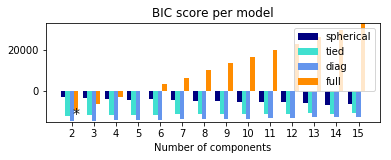

In [22]:
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.mixture import GaussianMixture
from sklearn import mixture
import itertools

n_components_range = range(2,16)
cv_types = ['spherical', 'tied', 'diag', 'full']
lowest_bic = np.infty
bic = []
for cv_type in cv_types:
    for n_components in n_components_range:
        # Fit a Gaussian mixture with EM
        gmm = mixture.GaussianMixture(n_components=n_components,
                                      covariance_type=cv_type)
        gmm.fit(ufeats)
        bic.append(gmm.bic(ufeats))
        if bic[-1] < lowest_bic:
            lowest_bic = bic[-1]
            best_gmm = gmm
            
bic = np.array(bic)
color_iter = itertools.cycle(['navy', 'turquoise', 'cornflowerblue',
                              'darkorange'])
clf = best_gmm
bars = []

# Plot the BIC scores
spl = plt.subplot(2, 1, 1)
for i, (cv_type, color) in enumerate(zip(cv_types, color_iter)):
    xpos = np.array(n_components_range) + .2 * (i - 2)
    bars.append(plt.bar(xpos, bic[i * len(n_components_range):
                                  (i + 1) * len(n_components_range)],
                        width=.2, color=color))
plt.xticks(n_components_range)
plt.ylim([bic.min() * 1.01 - .01 * bic.max(), bic.max()])
plt.title('BIC score per model')
xpos = np.mod(bic.argmin(), len(n_components_range)) + .65 +\
    .2 * np.floor(bic.argmin() / len(n_components_range))
plt.text(xpos, bic.min() * 0.97 + .03 * bic.max(), '*', fontsize=14)
spl.set_xlabel('Number of components')
spl.legend([b[0] for b in bars], cv_types)



In [ ]:
models = [GaussianMixture(n, covariance_type='diag', random_state=0).fit(ufeats) for n in n_components]
plt.plot(n_components, [m.bic(ufeats) for m in models], label='BIC')
plt.plot(n_components, [m.aic(ufeats) for m in models], label='AIC')
plt.legend(loc='best')
plt.xlabel('n_components')

In [14]:
from sklearn.cluster import DBSCAN
from sklearn import metrics
db = DBSCAN(eps=0.3).fit(ufeats)
core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True
db_labels = db.labels_

# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(db_labels)) - (1 if -1 in db_labels else 0)

print('Estimated number of clusters: %d' % n_clusters_)
print("Silhouette Coefficient: %0.3f" % metrics.silhouette_score(ufeats, db_labels))

Estimated number of clusters: 2
Silhouette Coefficient: 0.367


In [15]:
#cluster characteristics when 5 clusters for GMM and 3 for DBSCAN
gmm = GaussianMixture(8, covariance_type='full', random_state=0).fit(ufeats)
user_labels_gmm = gmm.predict(ufeats)
print user_labels_gmm

def indices( mylist, value):
    return [i for i,x in enumerate(mylist) if x==value]

gmm_clusters = {}
for n in range(8):
   gmm_clusters[n] = indices(user_labels_gmm, n)
    
#dbscan clusters
db_clusters = {}
for n in range(2):
    db_clusters[n] = indices(db_labels, n)

print 'gmm:', gmm_clusters
print 'db:',db_clusters

[0 0 5 1 5 4 1 2 1 1 1 1 2 2 4 1 2 1 2 7 4 1 0 6 1 0 2 2 4 0 4 3 4 5 1 4 0
 5 1 1]
gmm: {0: [0, 1, 22, 25, 29, 36], 1: [3, 6, 8, 9, 10, 11, 15, 17, 21, 24, 34, 38, 39], 2: [7, 12, 13, 16, 18, 26, 27], 3: [31], 4: [5, 14, 20, 28, 30, 32, 35], 5: [2, 4, 33, 37], 6: [23], 7: [19]}
db: {0: [3, 6, 8, 10, 11, 17, 21, 24, 34, 38, 39], 1: [7, 13, 16, 18, 26]}


In [16]:
for cluster in gmm_clusters.keys():
    users_in_cluster = gmm_clusters[cluster]
    print 'CLUSTER ', cluster
    for u in users_in_cluster:
        print users[u],':',user_feats[u]
        
print 'DBSCAN'
for cluster in db_clusters.keys():
    users_in_cluster = db_clusters[cluster]
    print 'CLUSTER ', cluster
    for u in users_in_cluster:
        print users[u],':',user_feats[u]

CLUSTER  0
1550 : [0.03332011106703689, 0.0, 0.05632685442284808, 0.6402221340737803, 0.005553351844506148, 0.26457754859182864, 0.3046875, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.2578125, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.2265625, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.09375, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.1171875]
1556 : [0.07774692582308608, 0.0, 0.003966679888932963, 0.64260214200714, 0.005553351844506148, 0.2701309004363348, 0.41044776119402987, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.029850746268656716, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.31343283582089554, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.07462686567164178, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.17164179104477612]
1791 : [0.0, 0.0, 0.03076923076923077, 0.8692307692307693, 0.0, 0.1, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.15, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.35]
1802 : [0.2901631240731587, 0.0, 0.

In [7]:
from sequenceminer import miner
seq = miner.read_sequences('seqpat.csv')
freq_seq = miner.mine(seq[:40], 1)
freq_seq

set([('2', '3'), ('3', '3')])


_KeyDefaultDict(sequenceminer.miner.Element,
                {('2',): {'events': set([Event(sid='0', eid='19')]), 'seq': ('2',)},
                 ('2',
                  '3'): {'events': set([Event(sid='0', eid='21'), Event(sid='0', eid='33'), Event(sid='0', eid='2'), Event(sid='0', eid='28'), Event(sid='0', eid='23'), Event(sid='0', eid='31'), Event(sid='0', eid='25'), Event(sid='0', eid='5'), Event(sid='0', eid='38'), Event(sid='0', eid='7'), Event(sid='0', eid='8'), Event(sid='0', eid='36'), Event(sid='0', eid='29'), Event(sid='0', eid='20'), Event(sid='0', eid='34'), Event(sid='0', eid='3'), Event(sid='0', eid='26'), Event(sid='0', eid='22'), Event(sid='0', eid='32'), Event(sid='0', eid='24'), Event(sid='0', eid='30'), Event(sid='0', eid='39'), Event(sid='0', eid='4'), Event(sid='0', eid='9'), Event(sid='0', eid='27'), Event(sid='0', eid='37'), Event(sid='0', eid='6'), Event(sid='0', eid='35')]), 'seq': ('2', '3')},
                 ('2',
                  '3',
                  '

In [55]:
user_duration.duration.describe()

count                            80
mean       381 days 08:20:48.424200
std       2258 days 15:56:02.395706
min          0 days 00:07:30.039000
25%          0 days 01:48:35.751250
50%          1 days 11:50:55.782500
75%         28 days 12:57:02.119000
max      15980 days 04:16:40.466000
Name: duration, dtype: object

In [ ]:
from pymining import seqmining
import pickle

seqs = pickle.load(open('activity_sequences.dump', 'rb'))
freq_seqs = seqmining.freq_seq_enum(seqs[:2], 1)
sorted(freq_seqs)

In [13]:
users_demo = demographics.user.unique()
users_raw = list(set(raw_data.user.unique()).union(set(lab_raw.user.unique())))
users_act = list(set(act_data.user.unique()).union(set(lab_act.user.unique())))
users_common_rawact = list(set(users_raw).intersection(set(users_act)))
users_common_all = list(set(users_common_rawact).intersection(set(users_demo)))
raw_not_demo = list(set(users_raw) - set(users_demo))
demo_not_raw = list(set(users_demo) - set(users_raw))
raw_demo_common = list(set(users_demo).intersection(set(users_raw)))
act_not_raw = list(set(users_act) - set(users_raw))
print len(users_demo), len(users_raw), len(users_act)
print len(users_common_rawact)
print len(users_common_all)
print len(raw_not_demo)
print len(demo_not_raw)
print len(raw_demo_common)
print len(act_not_raw)

525 325 168
161
34
290
490
35
7
